### Read packages, define cleaning and ploting functions

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt

warnings.filterwarnings("ignore")

In [54]:
def format_df(df, z_score=1.96):
    return (
        df.assign(
            site=lambda x: x["site_month"].str.split("_").str[0],
            date=lambda x: pd.to_datetime(
                x["site_month"].str.split("_").str[1:3].str.join(sep=""), format="%Y-%m"
            ),
            ci_lower=lambda x: x["fit"] - z_score * x["se.fit"],
            ci_upper=lambda x: x["fit"] + z_score * x["se.fit"],
        )
        .melt(id_vars=["site", "date"], value_vars=["fit", "ci_lower", "ci_upper"])
        .assign(
            variable_type=lambda x: x["variable"],
            variable=lambda x: x["variable"].map(
                {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
            ),
        )
        .rename(columns={"value": "slant"})
        .sort_values(by=["site", "date"])
    )

In [55]:
def format_pred(df):
    df["site"] = df["site_month"].str.split("_").apply(lambda x: x[0])

    z_score = 1.96
    df["ci_lower"] = df["fit"] - z_score * df["se.fit"]
    df["ci_upper"] = df["fit"] + z_score * df["se.fit"]

    df = df.melt(
        id_vars=["site", "year", "month"], value_vars=["fit", "ci_lower", "ci_upper"]
    )
    df["variable_type"] = df["variable"]
    df["variable"] = df["variable"].map(
        {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
    )

    df = df.rename(columns={"value": "slant"})

    df["date"] = pd.to_datetime(
        df["year"].astype(str) + df["month"].astype(str), format="%Y%m"
    )

    df["site"] = np.where(df["site"] == "24hu", "24.hu", df["site"])
    df["site"] = np.where(df["site"] == "index", "Index", df["site"])

    df = df.sort_values(by=["site", "date"])

    return df

In [56]:
def format_for_plot(df):
    return (
        df.melt(id_vars=["site", "date"], value_vars=["fit", "ci_lower", "ci_upper"])
        .assign(
            variable_type=lambda x: x["variable"],
            variable=lambda x: x["variable"].map(
                {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
            ),
        )
        .assign(site=lambda x: np.where(x["site"] == "24hu", "24.hu", x["site"]))
        .assign(site=lambda x: np.where(x["site"] == "index", "Index", x["site"]))
        .rename(columns={"value": "slant"})
        .sort_values(by=["site", "date"])
    )

In [57]:
def plot_slant(df, figname):
    plt.figure(figsize=(10, 7))
    sns.set_theme(style="darkgrid")
    sns.lineplot(
        x="date",
        y="slant",
        hue="site",
        style="variable",
        data=df.loc[
            lambda x: (x["date"] != df["date"].values[-1])
            & (x["date"] != df["date"].values[-2])
        ],
    )
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
    plt.savefig("../figures/" + figname)
    plt.show()

In [58]:
def plot_smooth_slant(df, figname, rolling_window=4):

    rolling_mean = (
        df.loc[lambda x: x.variable_type == "fit"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

    rolling_mean_upper = (
        df.loc[lambda x: x.variable_type == "ci_upper"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

    rolling_mean_lower = (
        df.loc[lambda x: x.variable_type == "ci_lower"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

    df_rolling = pd.concat(
        [
            df.loc[lambda x: x.variable_type == "fit"].assign(
                rolling_mean=rolling_mean
            ),
            df.loc[lambda x: x.variable_type == "ci_upper"].assign(
                rolling_mean=rolling_mean_upper
            ),
            df.loc[lambda x: x.variable_type == "ci_lower"].assign(
                rolling_mean=rolling_mean_lower
            ),
        ]
    ).reset_index(drop=True)

    df["variable"] = df["variable_type"].map(
        {"fit": "fit", "ci_upper": "ci", "ci_lower": "ci"}
    )

    plt.figure(figsize=(10, 7))
    sns.set_theme(style="darkgrid")
    sns.lineplot(
        x="date", y="rolling_mean", hue="site", style="variable", data=df_rolling
    )
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
    plt.title("Predicted slant of media outlets by month\nbased on Gentzkow-Shapiro (2010)",size=20)
    plt.ylabel("slant")
    plt.savefig("../figures/" + figname)
    plt.show()

## model 6
- trained on 14-18 speeches, without Jobbik
- 1000-1000 bi-trigrams
- smoothing parameter not used
- trained on individual speeches

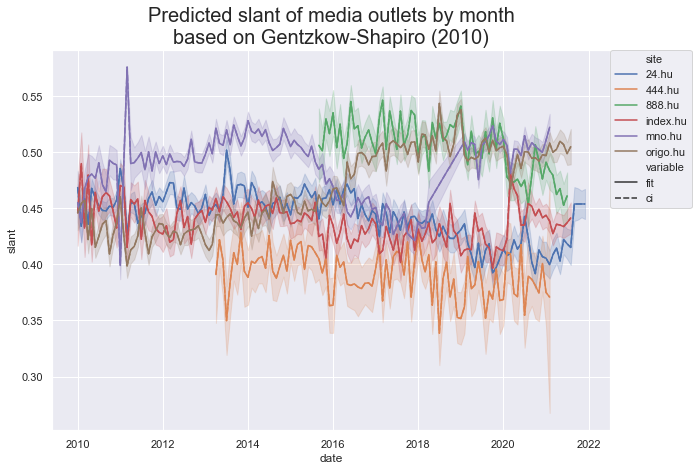

In [85]:
df = pd.concat([pd.read_csv("../data/output/monthly_slant_pred_" + str(year) + ".csv") for year in range(2010,2022)]).loc[lambda x: x["fit"]!=0]
df = format_df(df)

df = (df.merge(
        df.groupby(["variable_type", "date"])["slant"]
        .mean()
        .reset_index()
        .loc[lambda x: x["variable_type"] == "fit"]
        .rename(columns={"slant": "mean_slant"})
        .drop("variable_type", axis=1),
        on="date",
        how="left",
    ).assign(slant=lambda x: (x["slant"] - x["mean_slant"]) + x["slant"].mean()))

plot_smooth_slant(
    df,#.loc[lambda x: (x["site"] != "888.hu") & (x["site"] != "444.hu")],
    "slant_bymonth_1418_predspeech_wojobbik.png",
    rolling_window=1,
)

## read readership numbers

In [9]:
readership = (
    pd.read_csv("../data/input/real_users.csv")
    .rename({"page": "site"}, axis=1)
    .assign(date=lambda x: pd.to_datetime(x["date"], format="%Y-%m-%d"))
)

df = (
    pd.read_csv("../data/output/" + "monthly_pred_1418_wojobbik.csv")
    .assign(
        site=lambda x: x["site_month"].str.split("_").str[0],
        date=lambda x: pd.to_datetime(
            x["site_month"].str.split("_").str[1:3].str.join(sep=""), format="%Y%m"
        ),
    )
    .assign(site=lambda x: np.where(x["site"] == "24hu", "24.hu", x["site"]))
    .assign(site=lambda x: np.where(x["site"] == "index", "Index", x["site"]))
    .assign(
        site=lambda x: x["site"].map(
            {
                "24.hu": "24.hu",
                "Index": "index.hu",
                "telex": "telex.hu",
                "mno": "magyarnemzet.hu",
                "origo": "origo.hu",
                "444": "444.hu",
                "888": "888.hu",
            }
        )
    )
    .merge(readership, on=["site", "date"], how="left")
)
df["real_users"] = np.where(
    (df["site"] == "magyarnemzet.hu") & df["real_users"].isnull(), 0, df["real_users"]
)
df["real_users"] = np.where(
    (df["site"] == "888.hu") & df["real_users"].isnull(),
    np.nanmean(df.loc[lambda x: x["site"] == "888.hu", "real_users"]),
    df["real_users"],
)

# !!!
df = df.fillna(0)

df = df.merge(
    df.groupby(["date"])
    .apply(lambda x: np.average(x["fit"], weights=x["real_users"]))
    .to_frame(name="mean_slant")
    .reset_index(),
    on="date",
    how="left",
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/input/real_users.csv'

In [29]:
z_score = 1.96

df = df.assign(
    ci_lower=lambda x: x["fit"] - z_score * x["se.fit"],
    ci_upper=lambda x: x["fit"] + z_score * x["se.fit"],
)

In [33]:
df_raw = df.copy()

In [34]:
df = format_for_plot(df)
rolling_window = 4

In [35]:
rolling_mean = (
        df.loc[lambda x: x.variable_type == "fit"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

rolling_mean_upper = (
        df.loc[lambda x: x.variable_type == "ci_upper"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

rolling_mean_lower = (
        df.loc[lambda x: x.variable_type == "ci_lower"]
        .sort_values(by=["site", "date"])
        .groupby("site")["slant"]
        .rolling(rolling_window, center=True)
        .mean()
        .values
    )

df_rolling = pd.concat(
        [
            df.loc[lambda x: x.variable_type == "fit"].assign(
                rolling_mean=rolling_mean
            ),
            df.loc[lambda x: x.variable_type == "ci_upper"].assign(
                rolling_mean=rolling_mean_upper
            ),
            df.loc[lambda x: x.variable_type == "ci_lower"].assign(
                rolling_mean=rolling_mean_lower
            ),
        ]
    ).reset_index(drop=True)

In [36]:
rolling_mmean = (
    df_raw.filter(["date", "mean_slant"])
    .drop_duplicates("date")
    .assign(site="Mean slant", variable="fit", variable_type="fit")
    .rename({"mean_slant": "slant"}, axis=1)
    .sort_values(by=["site", "date"])
    .groupby("site")["slant"]
    .rolling(rolling_window, center=True)
    .mean()
    .values
)

df_rolling = pd.concat(
    [
        df_rolling,
        (
            df_raw.filter(["date", "mean_slant"])
            .drop_duplicates("date")
            .assign(site="Mean slant", variable="fit", variable_type="fit")
            .rename({"mean_slant": "slant"}, axis=1)
            .sort_values(by=["date"])
            .assign(rolling_mean=rolling_mmean)
        ),
    ]
)

In [37]:
df_rolling = df_rolling.assign(size=lambda x: np.where(x["site"] == "Mean slant", 1, 0))

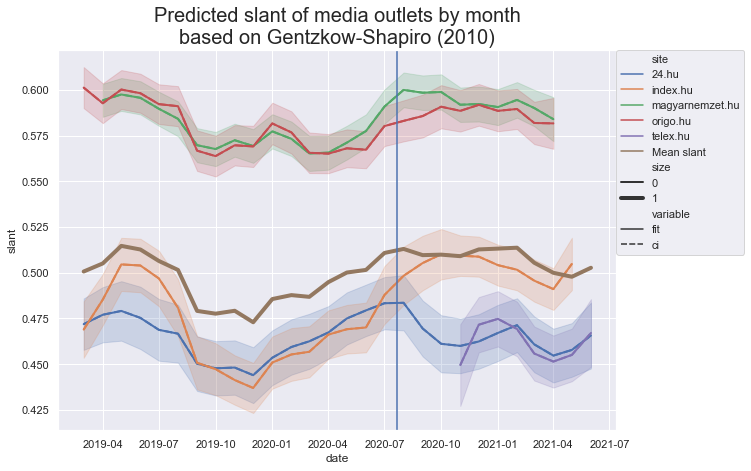

In [42]:
figname = "slant_bymonth_with_mean"

plt.figure(figsize=(10, 7))
sns.color_palette(palette="colorblind")
sns.lineplot(
    x="date",
    y="rolling_mean",
    hue="site",
    style="variable",
    data=df_rolling.loc[lambda x: (x["site"] != "444.hu") & (x["site"] != "888.hu")],
    size="size",
    sizes=[2, 4],
)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.title(
    "Predicted slant of media outlets by month\nbased on Gentzkow-Shapiro (2010)",
    size=20,
)
plt.axvline(dt.datetime(2020, 7, 22))
plt.ylabel("slant")
plt.savefig("../figures/" + figname)
plt.show()